<h1>Раздел 1<h1>
<h2>Основы работы с моделями нейронных сетей<h2/>

**Шаг 1**
Импорт библиотек, необходимых для работы.

In [ ]:
!pip install torchvision

In [ ]:
# для работы с тензорами и нейронными сетями
import torch
#  содержит слои, функции активации и т.д.
import torch.nn as nn
# содержит функции без сохранения состояния
import torch.nn.functional as F

#  для пакетной обработки данных и taset для создания пользовательских наборов данных
from torch.utils.data import DataLoader, Dataset

# Импорт готовых наборов данных из torchvision (например, MNIST, CIFAR-10)
from torchvision import datasets
# Импорт преобразований для изображений: ToTensor для конвертации в тензоры, Resize для изменения размера
from torchvision.transforms import ToTensor, Resize

#  для численных вычислений и работы с массивами
import numpy as np

# для построения графиков и визуализации
import matplotlib.pyplot as plt
# для работы с изображениями в matplotlib
import matplotlib.image as mpimg

**Шаг 2**
Загрузка открытых датасетов из пакета datasets фреймворка pytorch

In [ ]:
# Создание переменной training_data и загрузка обучающего набора данных FashionMNIST
training_data = datasets.FashionMNIST(
    # Указание директории, куда будут загружены данные
    root="data",
    # Параметр train=True указывает, что это обучающая выборка
    train=True,
    # Параметр download=True разрешает автоматическую загрузку данных, если они отсутствуют локально
    download=True,
    # Преобразование изображений в тензоры PyTorch с нормализацией значений пикселей в диапазон [0, 1]
    transform=ToTensor(),
)

# Создание переменной test_data и загрузка тестового набора данных FashionMNIST
test_data = datasets.FashionMNIST(
    # Указание той же директории для хранения данных
    root="data",
    # Параметр train=False указывает, что это тестовая выборка
    train=False,
    # Разрешение автоматической загрузки тестовых данных при необходимости
    download=True,
    # Применение того же преобразования ToTensor() к тестовым данным для согласованности
    transform=ToTensor(),
)

In [ ]:
# Загрузка классов данных, присутствующих в датасете
test_data.classes
#test_data.data

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

**Шаг 3**
После того, как датасеты были загружены, данные из них необходимо упаковать в пакеты (батчи). Основное преимущество нейросетей заключается в параллельной обработке данных, выполняющейся за счет того, что данные подаются на вход группами (батчами), то есть порциями. Чем больше размер пакета (батча), тем выше скорость обучения нейронной сети, но также возрастает ресурсоемкость сети. Таким образом, необходимо **выбирать размер пакета** таким образом, чтобы сохранялся **баланс между скоростью обучения и ресурсоемкостью**. <br/>
Для формирования пакетов используется класс DataLoader. С его помощью можно сформировать батчи необходимой длины, перемешать данные или добавить особую функцию (collate function), которая будет формировать пакеты.<br/>
В ячейке ниже предоставлены входные данные (тензор размерности [N, C, H, W], где N - размер пакета, C - количество каналов (1 - для ч/б изображений, 3 или 4 в зависимости от изображения RGB или RGBA), H и W - height и width, высота и ширина изображения). И выходные данные с указанием метки класса.

In [ ]:
# Определение размера пакета (количество образцов, обрабатываемых за одну итерацию)
batch_size = 64

# Создание загрузчика данных для обучающей выборки
train_dataloader = DataLoader(training_data, batch_size=batch_size)
# Создание загрузчика данных для тестовой выборки
test_dataloader = DataLoader(test_data, batch_size=batch_size)

# Итерация по тестовому загрузчику данных (будет выполняться только для первого пакета из-за break)
for X, y in test_dataloader:
    # Вывод формы тензора X (пакет данных) в формате [N, C, H, W]:
    # N - количество образцов в пакете, C - количество каналов, H - высота, W - ширина
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    # Вывод формы тензора y (метки) и его типа данных
    print(f"Shape of y: {y.shape} {y.dtype}")
    # Прерывание цикла после первой итерации для просмотра только первого пакета
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


**Шаг 4** Описание модели. Модель нейронной сети, создается фреймворком pytorch с помощью пакета torch.nn, который мы импортировали на шаге 1. <br/><br/>
Перед этим, необходимо выбрать устройство, на котором будет размещаться наша модель. Обычно существует два варианта: GPU/CUDA (видеокарта) или CPU (процессор). В google colab есть выбор запуска среды как с CUDA так и на CPU.
<br/><br/>
Для того, чтобы описать модель, необходимо создать класс, в нашем случае это класс NeuralNetwork, который будет наследовать интерфейс нейронной сети от класса nn.Module. Согласно этому интерфейсу в классе NeuralNetwork необходимо описать слои нейронной сети в конструкторе класса (*__init__*), а также порядок прохождения и обработки информации через слои с помощью перегрузки метода *forward*.
<br/><br/>
Подробное описание слоев предоставлено в комментариях в коде в ячейке ниже.

In [ ]:
# Определение устройства для обучения: проверка доступности CUDA (GPU), иначе использование CPU
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)
# Вывод информации о используемом устройстве
print(f"Используемое устройство: {device}")

# Определение класса нейронной сети, наследуемого от nn.Module
class NeuralNetwork(nn.Module):
    # Метод инициализации класса
    def __init__(self):
        # Вызов конструктора родительского класса nn.Module
        super().__init__()
        # Создание слоя для преобразования 2D-изображения в 1D-вектор
        self.flatten = nn.Flatten()
        # Создание последовательной модели из нескольких слоев
        self.linear_relu_stack = nn.Sequential(
            # Полносвязный слой с 28*28 входными нейронами и 512 выходными
            nn.Linear(28*28, 512),
            # Слой функции активации ReLU
            nn.ReLU(),
            # Второй полносвязный слой с 512 входными и 512 выходными нейронами
            nn.Linear(512, 512),
            # Второй слой функции активации ReLU
            nn.ReLU(),
            # Выходной полносвязный слой с 512 входными и 10 выходными нейронами (по числу классов)
            nn.Linear(512, 10)
        )

    # Метод прямого прохода (forward pass) определяет как данные проходят через сеть
    def forward(self, x):
        # Преобразование входного тензора в 1D-вектор
        x = self.flatten(x)
        # Пропускание данных через последовательность слоев
        logits = self.linear_relu_stack(x)
        # Возвращение выходных значений (логитов) без применения softmax
        return logits

# Создание экземпляра модели и перемещение ее на выбранное устройство (GPU/CPU)
model = NeuralNetwork().to(device)

print(model)

Используемое устройство: cuda
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


**Шаг 5** Выбор функции ошибок, алгоритмов оптимизации и определения функции обучения.

In [ ]:
#  в данном примере рассматривается многоклассовая классификация, поэтому наиболее
#  рациональным решением будет использование перекрестной энтропии (кросс-энтропии),
#  а в качестве примера алгоритм оптимизации Стохастичный Градиентный Спуск (SGD).
loss_fn = nn.CrossEntropyLoss()
#  параметр lr (learning_rate - шаг обучения) определяет размер шага, которым
#  алгоритм будет достигать максимума градиента.
#  При увеличении lr увеличивается скорость, но ухудшается точность, при уменьшении
#  увеличивается точность, но уменьшается скорость обучения.
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [ ]:
# Определение функции для обучения модели
def train(dataloader, model, loss_fn, optimizer):
    # Получение общего количества образцов в датасете
    size = len(dataloader.dataset)
    # Перевод модели в режим обучения (важно для слоев типа Dropout, BatchNorm)
    model.train()
    # Итерация по пакетам данных: batch - номер пакета, (X, y) - данные и метки
    for batch, (X, y) in enumerate(dataloader):
        # Перемещение входных данных и меток на выбранное устройство (GPU/CPU)
        X, y = X.to(device), y.to(device)

        #  вычисляем ошибку предсказания модели
        # Прямой проход: получение предсказаний модели для входных данных X
        pred = model(X)
        # Вычисление значения функции потерь между предсказаниями и истинными метками
        loss = loss_fn(pred, y)

        #  реализация метода обратного распространения ошибки
        # Вычисление градиентов функции потерь по параметрам модели
        loss.backward()
        #  backward вычисляет градиенты, а step производит обновление весов
        # Обновление параметров модели на основе вычисленных градиентов
        optimizer.step()
        #  метод zero_grad производит обнуление градиентов, чтобы это не мешало
        #  дальнейшему обучению сети
        # Обнуление градиентов для следующей итерации (чтобы они не накапливались)
        optimizer.zero_grad()

        # Вывод информации о процессе обучения каждые 100 пакетов
        if batch % 100 == 0:
            # Получение значения потерь как числа и вычисление количества обработанных образцов
            loss, current = loss.item(), (batch + 1) * len(X)

            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [ ]:
# Определение функции для тестирования модели
def test(dataloader, model, loss_fn):
    # Получение общего количества образцов в тестовом датасете
    size = len(dataloader.dataset)
    # Вычисление количества пакетов в даталоадере
    num_batches = len(dataloader)
    # Перевод модели в режим оценки (отключает слои типа Dropout, BatchNorm работает в inference mode)
    model.eval()
    # Инициализация переменных для накопления потерь и количества правильных предсказаний
    test_loss, correct = 0, 0
    # Контекстный менеджер для отключения вычисления градиентов (ускоряет вычисления и экономит память)
    with torch.no_grad():
        # Итерация по пакетам тестовых данных
        for X, y in dataloader:
            # Перемещение данных и меток на выбранное устройство
            X, y = X.to(device), y.to(device)
            # Прямой проход: получение предсказаний модели
            pred = model(X)
            # Накопление значения функции потерь для текущего пакета
            test_loss += loss_fn(pred, y).item()
            # Подсчет количества правильных предсказаний:
            # argmax(1) - получает индекс класса с максимальной вероятностью для каждого образца
            # (pred.argmax(1) == y) - булев тензор, где True соответствует правильному предсказанию
            # .type(torch.float) - преобразование булевых значений в числа (1.0 и 0.0)
            # .sum().item() - суммирование всех правильных предсказаний и преобразование в Python число
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Вычисление среднего значения потерь по всем пакетам
    test_loss /= num_batches
    # Вычисление доли правильных предсказаний (accuracy)
    correct /= size

    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

**Шаг 6** Обучение нейронной сети.<br/>
Эпоха, это итерация, на которой модель использует данные из обучающей выборки.
Согласно гипотезе, чем больше эпох, тем лучше, так как чем больше человек повторит какой либо материал, тем лучше он запомнит его.<br/>
Но в случае с нейронной сетью это не так. При увеличении числа эпох, в какой-то момент произойдет "переобучение сети", из-за чего точность на тестовой выборке начнет падать. Природа данного эффекта заключается в том, что модель слишком сильно настраивается на данные обучающей выборки, из-за чего теряется способность обобщающая способность нейронной сети. Более подробно см: https://proproprogs.ru/neural_network/pereobuchenie-chto-eto-i-kak-etogo-izbezhat-kriterii-ostanova-obucheniya?ysclid=lmlrjx3fbg719891347

In [ ]:
# Установка количества эпох обучения (количество полных проходов по всему набору данных)
epochs = 5
# Цикл по эпохам обучения, где t - номер текущей эпохи (начинается с 0)
for t in range(epochs):
    print(f"Эпоха {t+1}\n-------------------------------")
    # Вызов функции обучения для одной эпохи с передачей обучающего загрузчика, модели, функции потерь и оптимизатора
    train(train_dataloader, model, loss_fn, optimizer)
    # Вызов функции тестирования для оценки производительности модели на тестовых данных после эпохи обучения
    test(test_dataloader, model, loss_fn)

print("Готово!")

Эпоха 1
-------------------------------
loss: 2.305483  [   64/60000]
loss: 2.297647  [ 6464/60000]
loss: 2.279816  [12864/60000]
loss: 2.271473  [19264/60000]
loss: 2.250324  [25664/60000]
loss: 2.214527  [32064/60000]
loss: 2.229226  [38464/60000]
loss: 2.196179  [44864/60000]
loss: 2.199235  [51264/60000]
loss: 2.161726  [57664/60000]
Test Error: 
 Accuracy: 38.3%, Avg loss: 2.158726 

Эпоха 2
-------------------------------
loss: 2.172230  [   64/60000]
loss: 2.165569  [ 6464/60000]
loss: 2.115437  [12864/60000]
loss: 2.130444  [19264/60000]
loss: 2.067684  [25664/60000]
loss: 2.009802  [32064/60000]
loss: 2.041623  [38464/60000]
loss: 1.973609  [44864/60000]
loss: 1.985777  [51264/60000]
loss: 1.899436  [57664/60000]
Test Error: 
 Accuracy: 56.0%, Avg loss: 1.904132 

Эпоха 3
-------------------------------
loss: 1.939485  [   64/60000]
loss: 1.908565  [ 6464/60000]
loss: 1.808982  [12864/60000]
loss: 1.845174  [19264/60000]
loss: 1.715724  [25664/60000]
loss: 1.678296  [32064/600

Predicted: "Ankle boot", Actual: "Ankle boot"
Входное изображение:


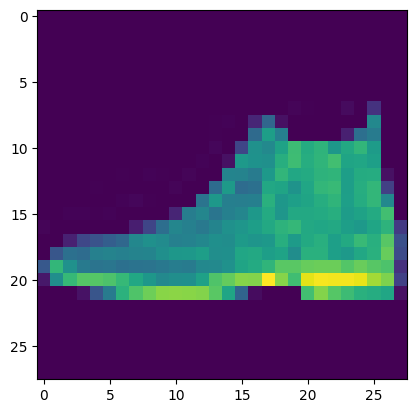

In [ ]:
# Определение списка с названиями классов для датасета FashionMNIST
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

# Перевод модели в режим оценки (отключает Dropout, BatchNorm и т.д.)
model.eval()
# Получение первого элемента из тестового датасета: x - изображение, y - соответствующая метка
x, y = test_data[0][0], test_data[0][1]
# Контекстный менеджер для отключения вычисления градиентов (экономит память и ускоряет вычисления)
with torch.no_grad():
    # Перемещение входного изображения на выбранное устройство (GPU/CPU)
    x = x.to(device)
    # Получение предсказания модели для входного изображения
    pred = model(x)
    # Определение предсказанного и фактического классов:
    # pred[0].argmax(0) - нахождение индекса максимального значения в выходном векторе (предсказанный класс)
    # classes[pred[0].argmax(0)] - преобразование индекса в название класса
    # classes[y] - преобразование числовой метки в название класса
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    # Вывод сравнения предсказанного и фактического классов
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
# Вывод заголовка перед отображением изображения
print("Входное изображение:")
# Отображение изображения с помощью matplotlib:
# x.detach().cpu().numpy() - отключение от графа вычислений, перемещение на CPU и преобразование в numpy array
# np.transpose(x.detach().cpu().numpy(), (1,2,0)) - изменение порядка осей для корректного отображения в matplotlib
plt.imshow(np.transpose(x.detach().cpu().numpy(), (1,2,0)))

<h1>Раздел 2<h1>
<h2>Визуализация работы ИИ<h2/>

**Шаг 1** Установка дополнительного пакета *torchcam* для визуализации зон изображений, на основе которых модель принимает решение.

In [ ]:
!pip install torch==1.13.1 torchvision==0.14.1 torchaudio==0.13.1
!pip install torchcam

ERROR: Could not find a version that satisfies the requirement torch==1.13.1 (from versions: 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0, 2.7.1, 2.8.0)
ERROR: No matching distribution found for torch==1.13.1


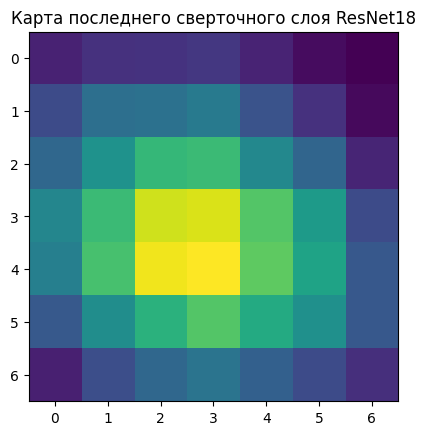

In [ ]:
# Импорт функции для чтения изображений из torchvision
from torchvision.io import read_image
# Импорт функциональных преобразований для изображений из torchvision
from torchvision.transforms.functional import normalize, resize, to_pil_image
# Импорт предобученной модели ResNet18 из torchvision
from torchvision.models import resnet18
# Импорт метода SmoothGradCAM++ из библиотеки torchcam для визуализации активаций
from torchvision import transforms

# Загрузка предобученной модели ResNet18 и перевод ее в режим оценки (inference)
model = resnet18(pretrained=True).eval()
# Создание экстрактора карт активации с использованием метода SmoothGradCAM++
cam_extractor = SmoothGradCAMpp(model)
# Открываем картинку
# Чтение изображения из файла "cat.jpg" в тензор PyTorch
img = read_image("cat.jpg")
# Предобрабатываем картинку для входа нашей нейронной сети
# Преобразование изображения: изменение размера до 224x224, нормализация в [0,1] и применение нормализации ImageNet
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Получаем выходные данные на основе модели
# Добавление размерности батча (unsqueeze(0)) и прямой проход через модель
out = model(input_tensor.unsqueeze(0))
# Получаем карту активации нейронов последнего слоя модели resnet18
# out.squeeze(0).argmax().item() - получение индекса предсказанного класса
# cam_extractor генерирует карту активации для этого класса
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
# Установка заголовка для графика
plt.title("Карта последнего сверточного слоя ResNet18")
# Отображение карты активации:
# Преобразование тензора активации в numpy array и изменение порядка осей для корректного отображения
plt.imshow(np.transpose(activation_map[0].detach().cpu().numpy(), (1, 2, 0)))

**Шаг 3** Наложение маски на исходное изображение

Открываем изображение с помощью cv2

In [ ]:
import cv2
img = cv2.imread("cat.jpg")

Растяжка карты до размеров исходного изображения

In [ ]:
heatmap = cv2.resize(activation_map[0].squeeze(0).numpy(), (img.shape[1], img.shape[0]))

Преобразование карты в RGB, наложение на изображение.

Text(0.5, 1.0, 'cat.jpg')

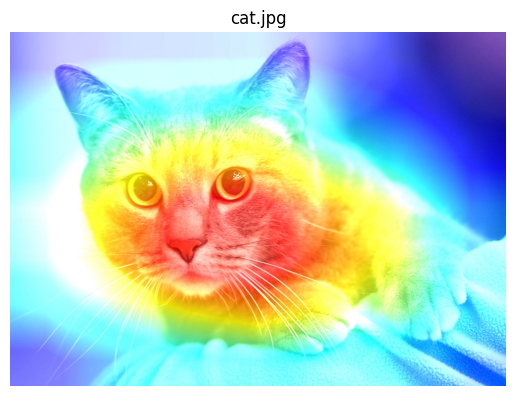

In [ ]:
# Загрузить фото кота в локальную среду выполнения ноутбука (сессионное хранилище)
# Преобразование карты тепла в 8-битный формат (диапазон 0-255) для использования с OpenCV
heatmap = np.uint8(255 * heatmap)
# Применение цветовой карты JET к карте тепла (преобразование в цветное изображение)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# Установка коэффициента прозрачности для наложения карты тепла на исходное изображение
hif = .8
# Наложение карты тепла на исходное изображение с заданной прозрачностью
superimposed_img = heatmap * hif + img
# Отображение результирующего изображения с наложенной картой тепла
plt.imshow(superimposed_img)
# Задание имени файла для сохранения результата
output = 'output.jpg'
# Сохранение изображения с наложенной картой тепла в файл с помощью OpenCV
cv2.imwrite(output, superimposed_img)
# Чтение сохраненного изображения с помощью matplotlib для последующего отображения
img=mpimg.imread(output)
# Отображение загруженного изображения
plt.imshow(img)
# Отключение осей координат на графике для лучшей визуализации
plt.axis('off')
# Установка заголовка графика
plt.title("cat.jpg")

<h1>Раздел 3</h1>
<h2>Применение state-of-the-art решений на примере датасета FGVAircraft</h2>

**Шаг 1** Аугментация данных.<br/>
Аугментация данных - это умышленное изменение/искажение исходных данных, для улучшения обобщающих способностей при обучении нейронной сети. В качестве аугментации изображений применяют различные повороты, наклоны изображений, изменение цветовых параметров пикселей и т.д.

In [ ]:
# описание функции трансформации изображений для реализации аугментаци
augmentation = transforms.Compose([
    # приведение матрицы к тензору pytorch
    ToTensor(),
    # уменьшение размера до 224 на 224 (требование большинства архитектур resnet, vgg ....)
    transforms.Resize((224, 224)),
    # случайное отражение по горизонтали
    transforms.RandomHorizontalFlip(),
    # слаучайное отражение по вертикали
    transforms.RandomVerticalFlip(),
    # случайный поворот изображения до 20 градусов
    transforms.RandomRotation(20),
    # случайное изменение яркости и оттенка изображения
    transforms.ColorJitter(brightness=.3, hue=.2)
])
# подробнее обо всех методах модуля transforms можно узнать в документации https://pytorch.org/vision/stable/transforms.html

In [ ]:
# Создание обучающего набора данных FGVCAircraft (самолеты Fine-Grained Visual Classification)
train = datasets.FGVCAircraft(
      # Указание директории для хранения данных
      "data",
      # Уровень аннотации: "manufacturer" - классификация по производителю самолетов
      annotation_level="manufacturer",
      # Использование обучающей части датасета (train split)
      split="train",
      # Разрешение автоматической загрузки данных при их отсутствии
      download=True,
      # Применение аугментаций данных (предположительно определенных ранее) к обучающим данным
      transform=augmentation
    )

# Создание тестового набора данных FGVCAircraft
test = datasets.FGVCAircraft(
      # Та же директория для хранения данных
      "data",
      # Тот же уровень аннотации по производителю для согласованности
      annotation_level="manufacturer",
      # Использование тестовой части датасета (test split)
      split="test",
      # Разрешение автоматической загрузки тестовых данных
      download=True,
      # Применение преобразований к тестовым данным: преобразование в тензор и изменение размера до 224x224 пикселей
      transform=transforms.Compose([ToTensor(), transforms.Resize((224, 224))])
    )

100%|██████████| 2.75G/2.75G [09:37<00:00, 4.77MB/s]


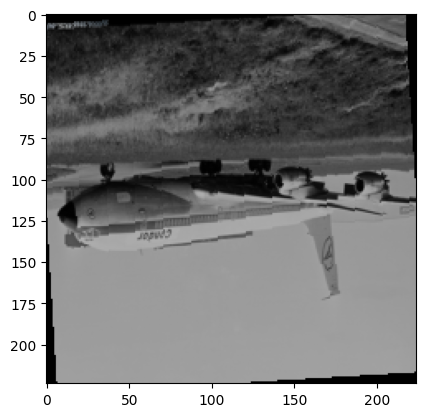

In [ ]:
# изображение после аугментации
plt.imshow(np.transpose(train[0][0], (1, 2, 0)))

In [ ]:
# создание загрузчиков данных, которые будут формировать и подавать данные пакетам на вход модели
train_dl = DataLoader(train, batch_size=16, shuffle=True)
test_dl = DataLoader(test, batch_size=4, shuffle=False)

**Шаг 2** Определение модели. Будем использовать готовую модель архитектуры resnet с 50 слоями.

In [ ]:
from torchvision.models import resnet50

# создание экземпляра модели и инициализация весами, полученными при обучении на датасете ImageNet
model = resnet50(pretrained=True)
model

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 205MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#  так как в филнальном размер выходного вектора больше необходимого нам количества классов, изменим его!
"Кол-во классов в датасете", len(train.classes), "Кол-во классов предсказываемых моделью:", model.fc.out_features

('Кол-во классов в датасете',
 30,
 'Кол-во классов предсказываемых моделью:',
 1000)

In [ ]:
#  изменение размерности выходного вектора и загрузка модели на устройство (cpu или gpu)
model.fc = nn.Linear(model.fc.in_features, len(train.classes))
model = model.to(device)

**Шаг 3** Обучение нейронной сети. Функция для обучения и теста написаны по аналогии с такими же в разделе 1.

In [ ]:
# Определение функции обучения модели с расчетом метрик
def train_fn(model, loader, criterion, optimizer):
    # Инициализация переменных для накопления потерь и точности за эпоху
    total_loss, total_acc = 0, 0

    # Перевод модели в режим обучения (включает Dropout, BatchNorm в train mode)
    model.train()

    # Итерация по пакетам данных: batch - номер пакета, (x, y) - данные и метки
    for batch, (x, y) in enumerate(loader):
      # Обнуление градиентов перед каждым пакетом
      optimizer.zero_grad()
      # Перемещение данных и меток на выбранное устройство (GPU/CPU)
      x,y = x.to(device), y.to(device)
      # Прямой проход: получение предсказаний модели
      out = model(x)

      # Вычисление функции потерь между предсказаниями и истинными метками
      loss = criterion(out, y)

      # рассчет точности
      # out.argmax(-1) - получение индексов предсказанных классов (по последнему измерению)
      # (out.argmax(-1) == y) - булев тензор правильных предсказаний
      # .sum() - подсчет количества правильных предсказаний в пакете
      # / out.size(0) - деление на размер пакета для получения accuracy пакета
      # Накопление accuracy по всем пакетам
      total_acc += (out.argmax(-1) == y).sum() / out.size(0)
      # Накопление значения потерь (преобразование в Python число)
      total_loss += loss.item()

      # Обратное распространение: вычисление градиентов
      loss.backward()
      # Шаг оптимизации: обновление весов модели
      optimizer.step()

      # Вывод прогресса обучения каждые 100 пакетов
      if (batch + 1) % 100 == 0:
        # Разделительная линия для визуального отделения вывода
        print("-" * 90)
        # Вывод средних потерь и точности, номера пакета и общего количества пакетов
        print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    # Возврат средних потерь и точности за всю эпоху (деление на общее количество пакетов)
    return total_loss / len(loader), total_acc / len(loader)

In [ ]:
# Определение функции для оценки модели на валидационной/тестовой выборке
def evaluate(model, loader, criterion):
    # Инициализация переменных для накопления точности и потерь
    total_acc, total_loss = 0, 0
    # Перевод модели в режим оценки (отключает Dropout, BatchNorm в inference mode)
    model.eval()

    # Контекстный менеджер для отключения вычисления градиентов (экономит память и ускоряет вычисления)
    with torch.no_grad():
      # Итерация по пакетам данных: batch - номер пакета, (x, y) - данные и метки
      for batch, (x,y) in enumerate(loader):
        # Перемещение данных и меток на выбранное устройство (GPU/CPU)
        x,y = x.to(device), y.to(device)
        # Прямой проход: получение предсказаний модели
        out = model(x)

        # Вычисление функции потерь между предсказаниями и истинными метками
        loss = criterion(out, y)

        # Расчет точности для текущего пакета:
        # out.argmax(-1) - получение индексов предсказанных классов (по последнему измерению)
        # (out.argmax(-1) == y) - булев тензор правильных предсказаний
        # .sum() - подсчет количества правильных предсказаний в пакете
        # / out.size(0) - деление на размер пакета для получения accuracy пакета
        total_acc += (out.argmax(-1) == y).sum() / out.size(0)
        # Накопление значения потерь (преобразование в Python число)
        total_loss += loss.item()

        # Вывод прогресса оценки каждые 100 пакетов
        if (batch + 1) % 100 == 0:
          # Разделительная линия для визуального отделения вывода
          print("-" * 90)
          # Вывод средних потерь и точности, номера пакета и общего количества пакетов
          print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    # Возврат средних потерь и точности за всю оценку (деление на общее количество пакетов)
    return total_loss / len(loader), total_acc / len(loader)

In [ ]:
# Установка количества эпох обучения
epochs = 5

# Инициализация списков для сохранения метрик обучения и тестирования по эпохам
train_accs, train_losses = [], []
test_accs, test_losses = [], []

# перекрестная энтропия для рассчета ошибки мультиклассовой классификации
# Создание функции потерь - кросс-энтропия для многоклассовой классификации
criterion = nn.CrossEntropyLoss()
# Создание оптимизатора Adam с learning rate 0.0001 для обновления параметров модели
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Вывод информации об устройстве, на котором происходит обучение
print(f"Process started on device: {device}")

# Цикл обучения по эпохам (от 1 до epochs включительно)
for epoch in range(1, epochs + 1):
    # Обучение модели на одной эпохе и получение потерь и точности
    loss, acc = train_fn(model, train_dl, criterion, optimizer)
    # Сохранение точности обучения: отключение от графа вычислений, перемещение на CPU и преобразование в число
    train_accs.append(acc.detach().cpu().item())
    # Сохранение потерь обучения (уже является числом)
    train_losses.append(loss)
    # Разделительная линия для визуального оформления
    print("-" * 90)
    # Вывод метрик обучения для текущей эпохи
    print(f"| epoch: {epoch} | train_acc: {acc} | train_loss: {loss} |")
    # Оценка модели на тестовых данных и получение потерь и точности
    eloss, eacc = evaluate(model, test_dl, criterion)
    # Сохранение точности тестирования: отключение от графа вычислений, перемещение на CPU и преобразование в число
    test_accs.append(eacc.detach().cpu().item())
    # Сохранение потерь тестирования
    test_losses.append(eloss)
    # Вывод метрик тестирования для текущей эпохи
    print(f"| epoch: {epoch} | test_acc: {eacc}  | test_loss: {eloss}  |")

Process started on device: cuda
------------------------------------------------------------------------------------------
loss: 2.662012823820114 acc: 0.2525 | batch: 100 / 209 |
------------------------------------------------------------------------------------------
loss: 2.372523793578148 acc: 0.3046875 | batch: 200 / 209 |
------------------------------------------------------------------------------------------
| epoch: 1 | train_acc: 0.307515949010849 | train_loss: 2.3555798502059644 |
------------------------------------------------------------------------------------------
loss: 0.9973863005638123 acc: 0.635 | batch: 100 / 834 |
------------------------------------------------------------------------------------------
loss: 0.96244951993227 acc: 0.615 | batch: 200 / 834 |
------------------------------------------------------------------------------------------
loss: 0.9387943525115648 acc: 0.6333333333333333 | batch: 300 / 834 |
----------------------------------------------

In [ ]:
# Импорт модуля itertools для работы с итераторами и комбинациями
import itertools
# Импорт функций для построения отчета классификации и матрицы ошибок из sklearn
from sklearn.metrics import classification_report, confusion_matrix


def accuracy(pred, y):
    """функция для расчета точности"""
    # Сравнение предсказанных классов (индексы максимальных значений) с истинными метками
    vals = (pred.argmax(-1) == y)
    # Возврат доли правильных предсказаний (сумма правильных деленная на общее количество)
    return vals.sum() / pred.size(0)


def build_classification_report(pred, y):
    """функция для построения отчета о классификации, выводит для каждого класса
    полноту, точность, Ф1 меру, поддержку, и макро и средне взвешенные метрики
    для всех классов"""
    # Создание и возврат отчета классификации с использованием названий классов из обучающего датасета
    return classification_report(y, pred, target_names=train.classes)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Матрица ошибок',
                          cmap=plt.cm.Blues):
    """функция для отображения матрицы ошибок классификации"""
    # Создание фигуры большого размера с высоким разрешением для четкого отображения
    plt.figure(figsize=(20,20), dpi=80)
    # Отображение матрицы ошибок как изображения с интерполяцией 'nearest' для четких границ
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # Установка заголовка графика
    plt.title(title)
    # Добавление цветовой шкалы для интерпретации значений
    plt.colorbar()
    # Создание меток для осей X и Y на основе количества классов
    tick_marks = np.arange(len(classes))
    # Установка меток на оси X с поворотом на 90 градусов для лучшей читаемости
    plt.xticks(tick_marks, classes, rotation=90)
    # Установка меток на оси Y
    plt.yticks(tick_marks, classes)

    # Нормализация матрицы ошибок (если требуется) для отображения долей вместо абсолютных значений
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Определение порогового значения для цвета текста (белый на темном фоне, черный на светлом)
    thresh = cm.max() / 2.
    # Итерация по всем ячейкам матрицы ошибок
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # Добавление текстовых значений в каждую ячейку матрицы
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 # Выбор цвета текста в зависимости от значения в ячейке
                 color="white" if cm[i, j] > thresh else "black")

    # Автоматическая настройка布局 для предотвращения наложения элементов
    plt.tight_layout()
    # Подпись оси Y (истинные метки)
    plt.ylabel('Истинные метки')
    # Подпись оси X (предсказанные метки)
    plt.xlabel('Предсказанные метки')

In [ ]:
#  прогон модели на тестовой выборке для получения меток для дальнейшего расчета метрик
# Инициализация пустых списков для хранения предсказаний и истинных меток
preds = []
ys = []
# Перевод модели в режим оценки (отключает Dropout, BatchNorm и т.д.)
model.eval()
# Контекстный менеджер для отключения вычисления градиентов (экономит память и ускоряет вычисления)
with torch.no_grad():
  # Итерация по пакетам тестовых данных: batch - номер пакета, (x, y) - данные и метки
  for batch, (x, y) in enumerate(test_dl):
    # Получение предсказаний модели для текущего пакета (перемещение данных на устройство)
    predicted = model(x.to(device))
    # Добавление предсказанных классов в список preds:
    # predicted.argmax(-1) - получение индексов классов с максимальной вероятностью
    # .detach() - отключение от графа вычислений
    # .cpu() - перемещение на CPU
    # .tolist() - преобразование тензора в Python список
    preds.extend(predicted.argmax(-1).detach().cpu().tolist())
    # Добавление истинных меток в список ys (преобразование тензора в Python список)
    ys.extend(y.tolist())

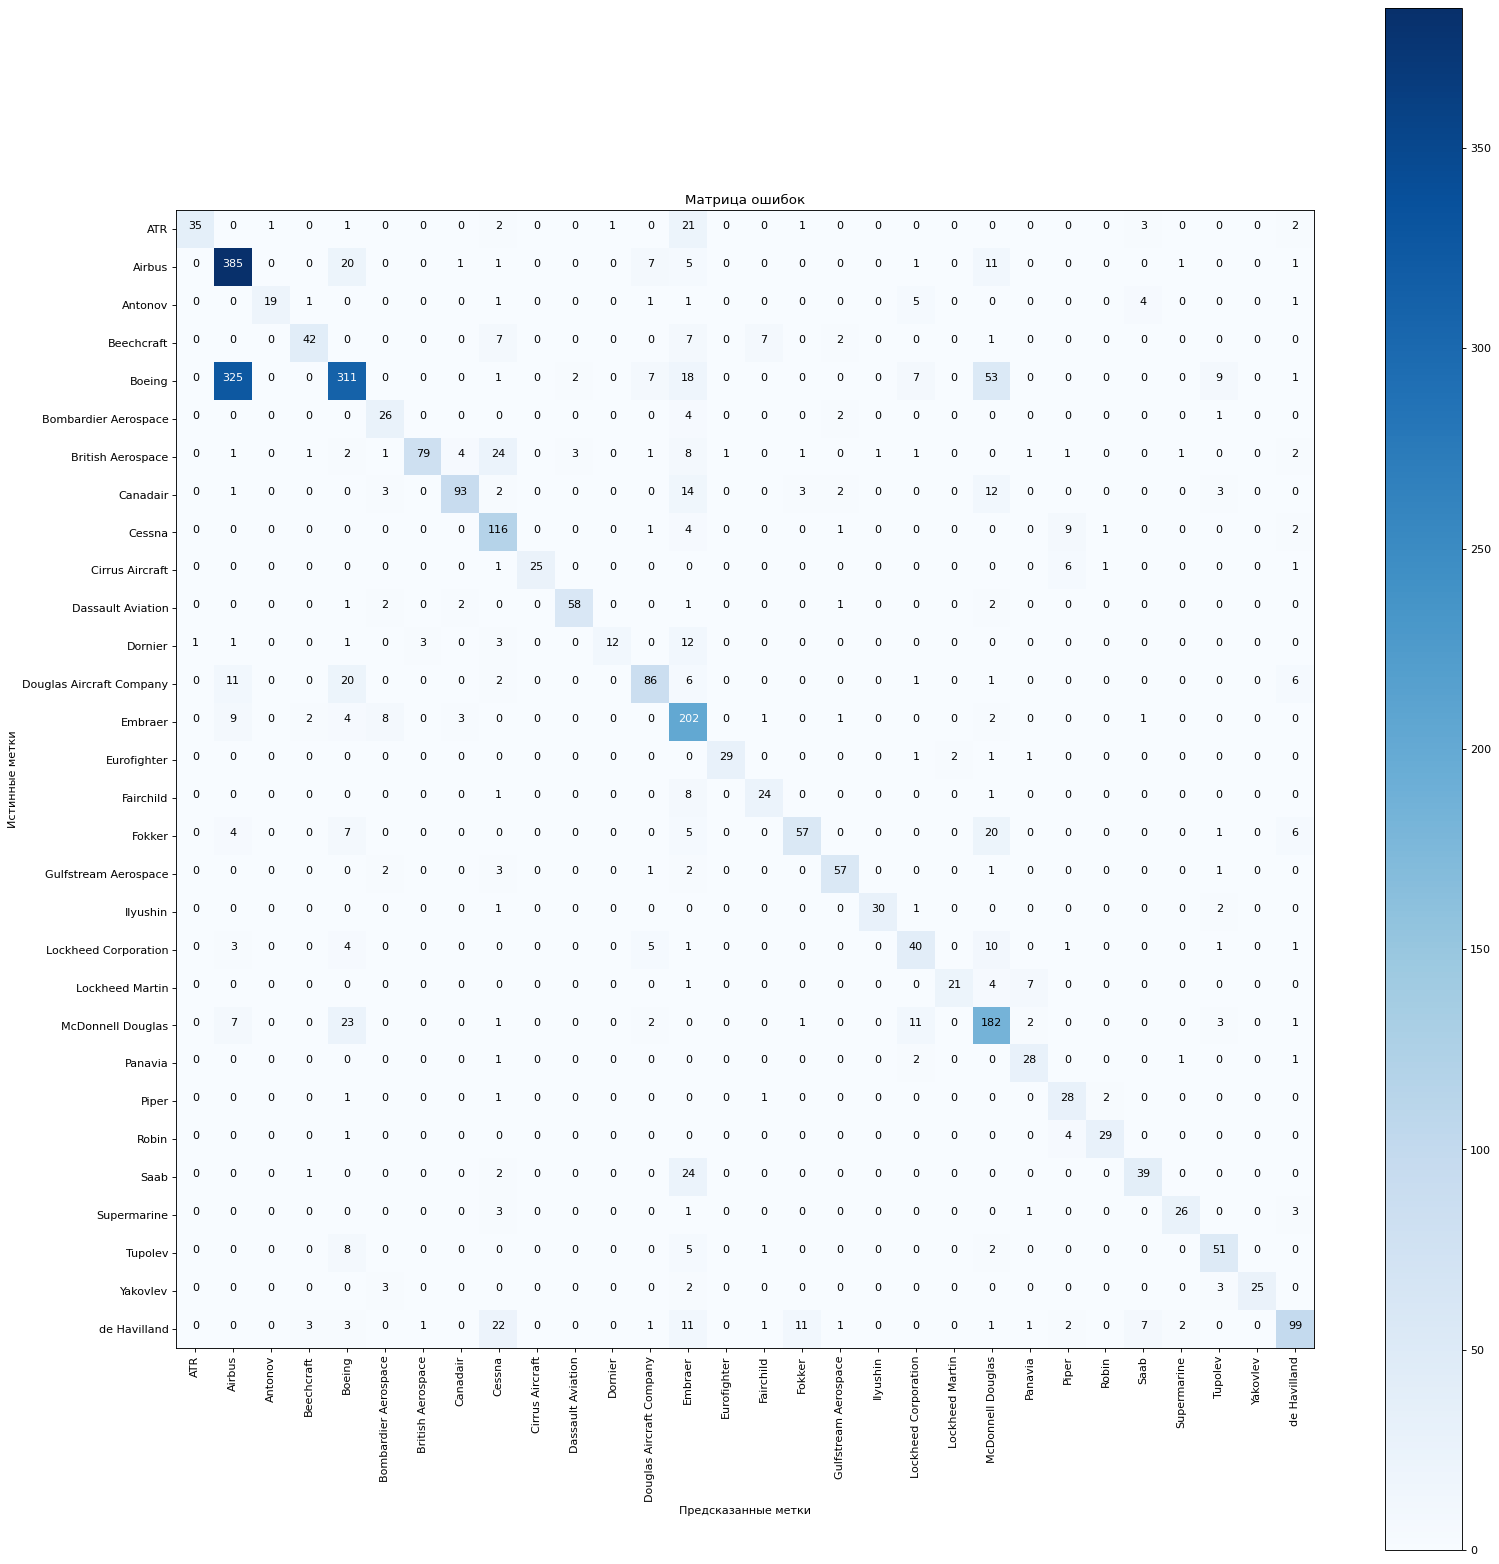

In [ ]:
plot_confusion_matrix(confusion_matrix(ys, preds), train.classes)

In [ ]:
# не имеет смысла в данном случае, так как слишком много классов
# самостоятельно измените функцию build_classification_report для вывода отчета в файл!
build_classification_report(preds, ys)

'                          precision    recall  f1-score   support\n\n                     ATR       0.97      0.52      0.68        67\n                  Airbus       0.52      0.89      0.65       433\n                 Antonov       0.95      0.58      0.72        33\n              Beechcraft       0.84      0.64      0.72        66\n                  Boeing       0.76      0.42      0.55       734\n    Bombardier Aerospace       0.58      0.79      0.67        33\n       British Aerospace       0.95      0.59      0.73       133\n                Canadair       0.90      0.70      0.79       133\n                  Cessna       0.59      0.87      0.71       134\n         Cirrus Aircraft       1.00      0.74      0.85        34\n       Dassault Aviation       0.92      0.87      0.89        67\n                 Dornier       0.92      0.36      0.52        33\nDouglas Aircraft Company       0.77      0.65      0.70       133\n                 Embraer       0.56      0.87      0.68    

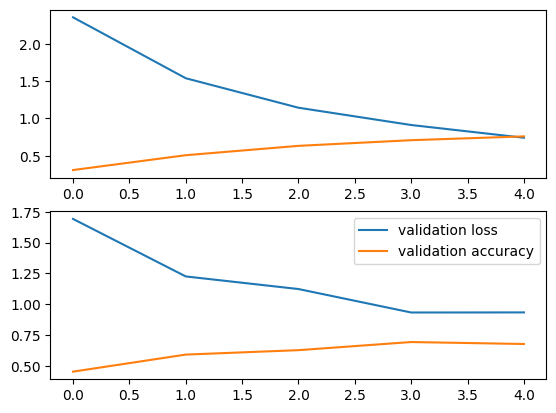

In [ ]:
# график изменения ошибки и точности от эпохи
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(train_losses, label = 'training loss')
fig1.plot(train_accs, label = 'training accuracy')
fig2.plot(test_losses, label = 'validation loss')
fig2.plot(test_accs, label = 'validation accuracy')
plt.legend()
plt.show()

**Задание** создайте тепловую карту последнего сверточного слоя модели resnet50, посмотрите и проанализируйте, корректно ли модель делает акцент для принятия решения или использует косвенные признаки (читерит)!

<H1>Раздел 4</H1>
<h2>Классификация дорожных знаков</h2>

In [ ]:
# Определение функции для создания pipeline аугментаций с заданным размером изображения
def augmentation_fn_builder(img_size):
    # Создание композиции преобразований для аугментации данных
    augmentation = transforms.Compose([
        # Преобразование изображения в тензор PyTorch
        ToTensor(),
        # Изменение размера изображения до квадрата img_size x img_size
        transforms.Resize((img_size, img_size)),
        # "дополните функцию другими методами аугментации изображений"
        # Здесь можно добавить другие методы аугментации: повороты, отражения, изменение яркости и т.д.
    ])
    return augmentation


# Создание обучающего набора данных GTSRB (German Traffic Sign Recognition Benchmark)
train = datasets.GTSRB(
    # Директория для хранения данных
    "data",
    # Использование обучающей части датасета
    split="train",
    # Разрешение автоматической загрузки данных
    download=True,
    # Применение аугментаций с размером изображения 224x224 пикселей
    transform=augmentation_fn_builder(224)
)

# Создание тестового набора данных GTSRB
test = datasets.GTSRB(
    # Та же директория для хранения данных
    "data",
    # Использование тестовой части датасета
    split="test",
    # Разрешение автоматической загрузки тестовых данных
    download=True,
    # Применение базовых преобразований к тестовым данным: преобразование в тензор и изменение размера
    transform=transforms.Compose([ToTensor(), transforms.Resize((224, 224))])
)

100%|██████████| 187M/187M [00:13<00:00, 13.6MB/s]
100%|██████████| 89.0M/89.0M [00:14<00:00, 6.19MB/s]
100%|██████████| 99.6k/99.6k [00:00<00:00, 194kB/s]


In [ ]:
# Создание пустого списка для хранения уникальных меток классов
unique = []
# Итерация по всем элементам обучающего датасета: x - изображение, y - метка класса
for x, y in train:
  # Проверка, есть ли текущая метка y в списке уникальных меток
  if y not in unique:
    # Если метка новая, добавляем ее в список уникальных меток
    unique.append(y)
# Вывод количества уникальных классов в датасете (длина списка unique)
len(unique)

43

In [ ]:
# Создание DataLoader для обучающего набора данных
train_dl = DataLoader(train, batch_size=16, shuffle=True)
# Создание DataLoader для тестового набора данных
test_dl = DataLoader(test, batch_size=14, shuffle=False)

In [ ]:
# Загрузка предобученной модели ResNet50
model = resnet50(pretrained=True)
# Замена последнего полносвязного слоя (fc) для соответствия количеству классов в нашем датасете
# Исходный слой: 2048 входных features -> 1000 выходных (ImageNet)
# Новый слой: 2048 входных features -> len(unique) выходных (количество классов в нашем датасете)
model.fc = nn.Linear(2048, len(unique))
# Перемещение всей модели на выбранное устройство (GPU/CPU)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Определение функции для обучения модели
def train_fn(model, loader, criterion, optimizer):
    # Инициализация переменных для накопления потерь и точности за эпоху
    total_loss, total_acc = 0, 0

    # Перевод модели в режим обучения (включает Dropout, BatchNorm в train mode)
    model.train()

    # Итерация по пакетам данных: batch - номер пакета, (x, y) - данные и метки
    for batch, (x, y) in enumerate(loader):
      # Обнуление градиентов перед обработкой каждого пакета
      optimizer.zero_grad()
      # Перемещение данных и меток на выбранное устройство (GPU/CPU)
      x,y = x.to(device), y.to(device)
      # Прямой проход: получение предсказаний модели
      out = model(x)

      # Вычисление функции потерь между предсказаниями и истинными метками
      loss = criterion(out, y)

      # рассчет точности
      # out.argmax(-1) - получение индексов предсказанных классов (по последнему измерению)
      # (out.argmax(-1) == y) - булев тензор правильных предсказаний
      # .sum() - подсчет количества правильных предсказаний в пакете
      # / out.size(0) - деление на размер пакета для получения accuracy пакета
      total_acc += (out.argmax(-1) == y).sum() / out.size(0)
      # Накопление значения потерь (преобразование в Python число)
      total_loss += loss.item()

      # Обратное распространение: вычисление градиентов
      loss.backward()
      # Шаг оптимизации: обновление весов модели
      optimizer.step()

      # Вывод прогресса обучения каждые 100 пакетов
      if (batch + 1) % 100 == 0:
        # Разделительная линия для визуального отделения вывода
        print("-" * 90)
        # Вывод средних потерь и точности, номера пакета и общего количества пакетов
        print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    # Возврат средних потерь и точности за всю эпоху (деление на общее количество пакетов)
    return total_loss / len(loader), total_acc / len(loader)


# Определение функции для оценки модели на валидационной/тестовой выборке
def evaluate(model, loader, criterion):
    # Инициализация переменных для накопления точности и потерь
    total_acc, total_loss = 0, 0
    # Перевод модели в режим оценки (отключает Dropout, BatchNorm в inference mode)
    model.eval()

    # Контекстный менеджер для отключения вычисления градиентов (экономит память и ускоряет вычисления)
    with torch.no_grad():
      # Итерация по пакетам данных: batch - номер пакета, (x, y) - данные и метки
      for batch, (x,y) in enumerate(loader):
        # Перемещение данных и меток на выбранное устройство (GPU/CPU)
        x,y = x.to(device), y.to(device)
        # Прямой проход: получение предсказаний модели
        out = model(x)

        # Вычисление функции потерь между предсказаниями и истинными метками
        loss = criterion(out, y)

        # Расчет точности для текущего пакета:
        # out.argmax(-1) - получение индексов предсказанных классов (по последнему измерению)
        # (out.argmax(-1) == y) - булев тензор правильных предсказаний
        # .sum() - подсчет количества правильных предсказаний в пакете
        # / out.size(0) - деление на размер пакета для получения accuracy пакета
        total_acc += (out.argmax(-1) == y).sum() / out.size(0)
        # Накопление значения потерь (преобразование в Python число)
        total_loss += loss.item()

        # Вывод прогресса оценки каждые 100 пакетов
        if (batch + 1) % 100 == 0:
          # Разделительная линия для визуального отделения вывода
          print("-" * 90)
          # Вывод средних потерь и точности, номера пакета и общего количества пакетов
          print("loss:", total_loss / (batch + 1), "acc:", total_acc.item() / (batch + 1), "| batch:", batch+1, "/", len(loader), "|")
    # Возврат средних потерь и точности за всю оценку (деление на общее количество пакетов)
    return total_loss / len(loader), total_acc / len(loader)

In [ ]:
# Установка количества эпох обучения (в данном случае только 1 эпоха)
epochs = 1

# Инициализация списков для сохранения метрик обучения и тестирования по эпохам
train_accs, train_losses = [], []
test_accs, test_losses = [], []

# перекрестная энтропия для рассчета ошибки мультиклассовой классификации
# Создание функции потерь - кросс-энтропия для многоклассовой классификации
criterion = nn.CrossEntropyLoss()
# Создание оптимизатора Adam с learning rate 0.0001 для обновления параметров модели
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Вывод информации об устройстве, на котором происходит обучение
print(f"Process started on device: {device}")

# Цикл обучения по эпохам (от 1 до epochs включительно, в данном случае только 1 эпоха)
for epoch in range(1, epochs + 1):
    # Обучение модели на одной эпохе и получение потерь и точности
    loss, acc = train_fn(model, train_dl, criterion, optimizer)
    # Сохранение точности обучения: отключение от графа вычислений, перемещение на CPU и преобразование в число
    train_accs.append(acc.detach().cpu().item())
    # Сохранение потерь обучения (уже является числом)
    train_losses.append(loss)
    # Разделительная линия для визуального оформления
    print("-" * 90)
    # Вывод метрик обучения для текущей эпохи
    print(f"| epoch: {epoch} | train_acc: {acc} | train_loss: {loss} |")
    # Оценка модели на тестовых данных и получение потерь и точности
    eloss, eacc = evaluate(model, test_dl, criterion)
    # Сохранение точности тестирования: отключение от графа вычислений, перемещение на CPU и преобразование в число
    test_accs.append(eacc.detach().cpu().item())
    # Сохранение потерь тестирования
    test_losses.append(eloss)
    # Вывод метрик тестирования для текущей эпохи
    print(f"| epoch: {epoch} | test_acc: {eacc}  | test_loss: {eloss}  |")

Process started on device: cuda
------------------------------------------------------------------------------------------
loss: 2.0260115033388137 acc: 0.510625 | batch: 100 / 1665 |
------------------------------------------------------------------------------------------
loss: 1.323020285256207 acc: 0.68375 | batch: 200 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.9715643079330524 acc: 0.7704166666666666 | batch: 300 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.767439026129432 acc: 0.820625 | batch: 400 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.6345510812699795 acc: 0.852375 | batch: 500 / 1665 |
------------------------------------------------------------------------------------------
loss: 0.5395626339657853 acc: 0.8745833333333334 | batch: 600 / 1665 |
---------------------------------------

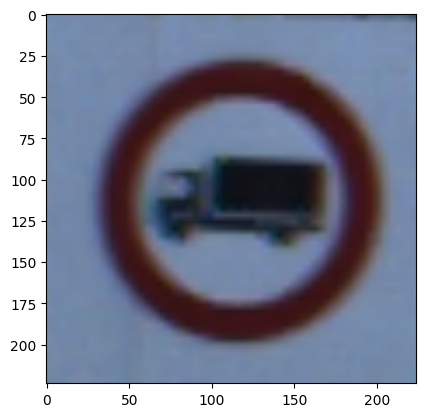

In [ ]:
plt.imshow(np.transpose(test[0][0], (1, 2, 0)))

Создаем тепловую карту последнего сверточного слоя сети

In [ ]:
to_pil_image(test[0][0]).save("sign.png")
torch.save(model.cpu().state_dict(), "resnet50.pt")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


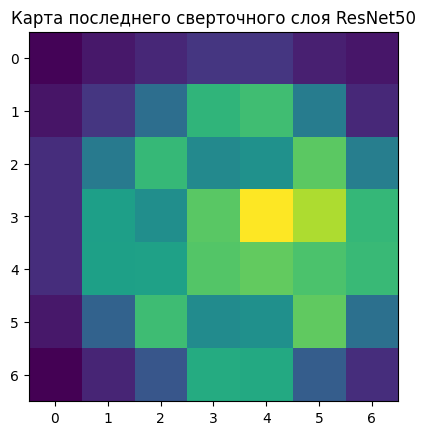

In [ ]:
# Создание модели ResNet50 без предобученных весов (с случайной инициализацией)
model = resnet50(pretrained=False)
# Замена последнего полносвязного слоя для соответствия количеству классов в нашем датасете
model.fc = nn.Linear(2048, len(unique))
# Перевод модели в режим оценки (отключает Dropout, BatchNorm и т.д.)
model = model.eval()
# Загрузка сохраненных весов модели из файла "resnet50.pt"
model.load_state_dict(torch.load("resnet50.pt"))
# Создание экстрактора карт активации с использованием метода SmoothGradCAM++
cam_extractor = SmoothGradCAMpp(model)
# Открываем картинку
# Чтение сохраненного изображения дорожного знака из файла
img = read_image("sign.png")
# Предобрабатываем картинку для входа нашей нейронной сети
# Преобразование изображения: изменение размера до 224x224, нормализация в [0,1] и применение нормализации ImageNet
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

# Получаем выходные данные на основе модели
# Добавление размерности батча (unsqueeze(0)) и прямой проход через модель
out = model(input_tensor.unsqueeze(0))
# Получаем карту активации нейронов последнего слоя модели resnet50
# out.squeeze(0).argmax().item() - получение индекса предсказанного класса
# cam_extractor генерирует карту активации для этого класса
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
# Установка заголовка для графика с указанием модели ResNet50
plt.title("Карта последнего сверточного слоя ResNet50")
# Отображение карты активации:
# Преобразование тензора активации в numpy array и изменение порядка осей для корректного отображения
plt.imshow(np.transpose(activation_map[0].detach().cpu().numpy(), (1, 2, 0)))

Text(0.5, 1.0, 'sign.png')

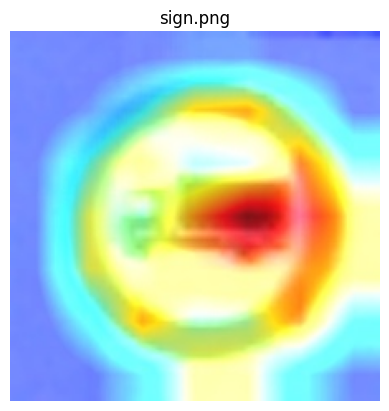

In [ ]:
# действия аналогичны разделу 2
# Чтение исходного изображения дорожного знака с помощью OpenCV
img = cv2.imread("sign.png")
# Изменение размера карты активации до размеров исходного изображения
heatmap = cv2.resize(activation_map[0].squeeze(0).numpy(), (img.shape[1], img.shape[0]))
# Преобразование карты тепла в 8-битный формат (диапазон 0-255) для использования с OpenCV
heatmap = np.uint8(255 * heatmap)
# Применение цветовой карты JET к карте тепла (преобразование в цветное изображение)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# Установка коэффициента прозрачности для наложения карты тепла на исходное изображение
hif = .8
# Наложение карты тепла на исходное изображение с заданной прозрачностью
superimposed_img = heatmap * hif + img
# Отображение результирующего изображения с наложенной картой тепла
plt.imshow(superimposed_img)
# Задание имени файла для сохранения результата
output = 'output.jpg'
# Сохранение изображения с наложенной картой тепла в файл с помощью OpenCV
cv2.imwrite(output, superimposed_img)
# Чтение сохраненного изображения с помощью matplotlib для последующего отображения
img=mpimg.imread(output)
# Отображение загруженного изображения
plt.imshow(img)
# Отключение осей координат на графике для лучшей визуализации
plt.axis('off')
# Установка заголовка графика с именем исходного файла
plt.title("sign.png")